In [17]:
import argparse
import itertools as it
import os
from tqdm import tqdm
import torch
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import cv2
from collections import namedtuple
from sklearn.metrics import auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from collections import defaultdict
from PIL import Image
import math
import random
import pickle
import sys

import torch
from torch.utils import data
from torch.utils.data.dataloader import default_collate
from torch.autograd import Variable
import torchvision.transforms as transforms

try:
    from kornia.augmentation import *
except:
    print("Error importing kornia augmentation")

root_dir = os.getcwd()
os.chdir('/scratch/ainaz/omnidata2')
from models.unet import UNet

os.chdir('/scratch/sasha/')
sys.path.insert(1, '/scratch/sasha/')
import soda as tta

os.chdir('/scratch/sasha/omnidata/')
from transform_params import ALL_TRANSFORMS

os.chdir(root_dir)




Error importing kornia augmentation


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def vis_normal(im):
    im = np.copy(im.transpose(1, 2, 0))
    im = (im + 1) / 2 * 255.0
    return im
  
def run(model, list_of_imgs, out_folder, b_vis_normal=False):
    print("####################################")
    print("Infering... Saving to %s" % out_folder)

#     assert not model.training

    iter = 0
    with torch.no_grad():
        for img_fname in tqdm(list_of_imgs):
            iter += 1
    #         color = cv2.imread(img_fname).astype(np.float32)
            img_path = os.path.join('/scratch/ainaz/OASIS/OASIS_test/image/', img_fname.split('/')[-1])
            color = np.array(Image.open(img_path)).astype(np.float32)

            orig_height = color.shape[0]
            orig_width = color.shape[1]
            h, w = 640, int(640 * orig_width / orig_height)

            target_res = color.shape[:2]
            color = cv2.resize(color, (h, w))
            color = color.transpose(2, 0, 1).astype(np.float32) / 255.0	

            color = np.expand_dims(color, axis = 0)
            inputs = torch.from_numpy(color)

            input_var = Variable(inputs.to(device))        
            size = 640
            input_var = torch.nn.functional.interpolate(input_var, size=(size, size), mode='bilinear')
            output_var = model(input_var)
            output_var = torch.nn.functional.interpolate(output_var, size=(orig_height, orig_width), mode='nearest')
            output_var = torch.clamp(output_var, -1, 1)

            pred_np = output_var.cpu().detach().numpy()[0,:,:,:]
            pred_np = pred_np.transpose(1, 2, 0)


            #######################################################################
            # save to output folder
            # orig_size_pred_np = cv2.resize(pred_np, (target_res[1], target_res[0]))
            img_id = os.path.basename(img_fname).replace(".png", "")   
            np.save("%s/%s.npy" % (out_folder, img_id), pred_np)

            if iter < 20:
                vis = ((pred_np + 1.0) / 2.0 * 255.0).astype(np.uint8)
                input_var = torch.nn.functional.interpolate(input_var, size=(orig_height, orig_width), mode='bilinear')
                rgb = input_var.cpu().detach().numpy()[0,:,:,:]
                rgb = (rgb.transpose(1, 2, 0) * 255).astype(np.uint8)
                im = np.concatenate([rgb, vis], axis=1)
                plt.imshow(im)
                plt.show()


def get_img_list(csv_filename):
    img_names = []
  
    with open(csv_filename, "r") as f:
        lines = [line.strip() for line in f]
        lines = lines[1:] 	#skip the header
  
    for line in lines:
        splits = line.split(",")
        if splits[-1] != '' and splits[4] != '':
            img_names.append(splits[0])
    
    return img_names

  0%|          | 0/20000 [00:00<?, ?it/s]




+----------------------------------+
|  best_MAE
+----------------------------------+
Testing on /scratch/ainaz/OASIS/OASIS_test/OASIS_test.csv
####################################
Infering... Saving to /scratch/ainaz/OASIS/normals


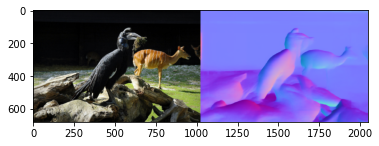

  0%|          | 1/20000 [00:01<10:34:00,  1.90s/it]

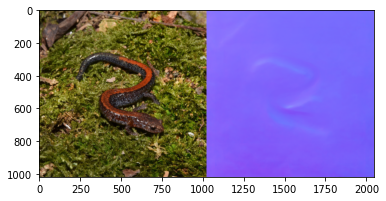

  0%|          | 2/20000 [00:03<10:39:54,  1.92s/it]

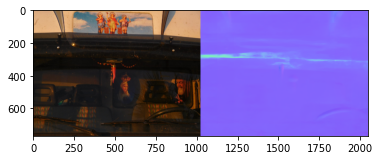

  0%|          | 3/20000 [00:05<10:36:20,  1.91s/it]

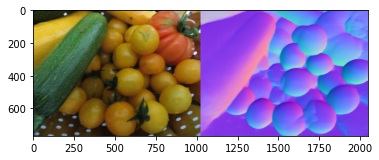

  0%|          | 4/20000 [00:07<10:40:31,  1.92s/it]

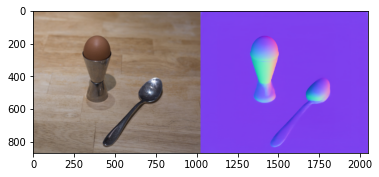

  0%|          | 5/20000 [00:09<10:44:38,  1.93s/it]

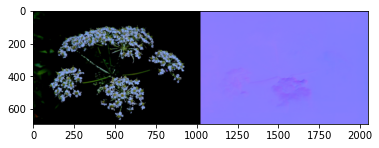

  0%|          | 6/20000 [00:11<10:34:54,  1.91s/it]

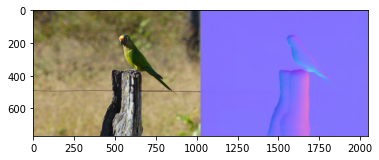

  0%|          | 7/20000 [00:13<10:31:47,  1.90s/it]

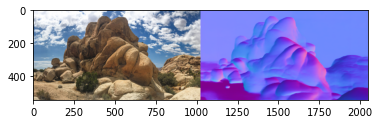

  0%|          | 8/20000 [00:15<10:41:00,  1.92s/it]

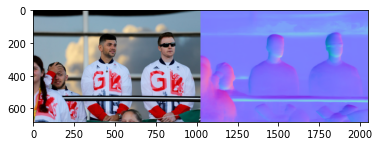

  0%|          | 9/20000 [00:17<10:35:53,  1.91s/it]

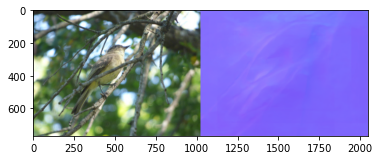

  0%|          | 10/20000 [00:19<10:33:04,  1.90s/it]

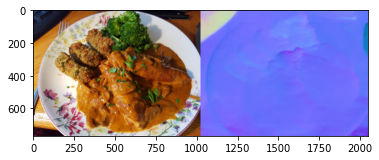

  0%|          | 11/20000 [00:20<10:30:53,  1.89s/it]

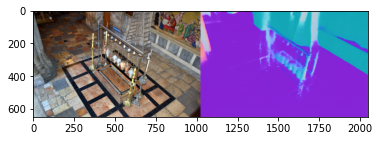

  0%|          | 12/20000 [00:22<10:29:47,  1.89s/it]

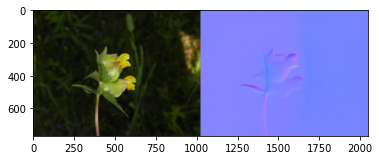

  0%|          | 13/20000 [00:24<10:32:14,  1.90s/it]

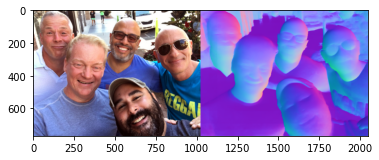

  0%|          | 14/20000 [00:26<10:34:20,  1.90s/it]

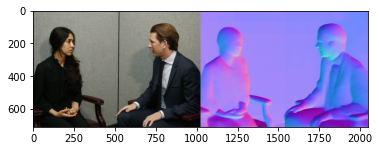

  0%|          | 15/20000 [00:28<10:31:29,  1.90s/it]

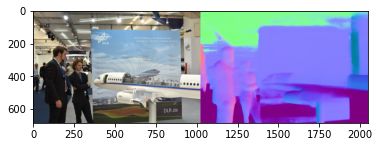

  0%|          | 16/20000 [00:30<10:29:17,  1.89s/it]

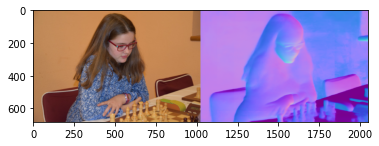

  0%|          | 17/20000 [00:32<10:20:49,  1.86s/it]

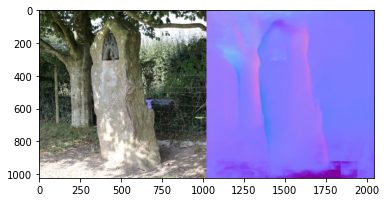

  0%|          | 18/20000 [00:34<10:29:02,  1.89s/it]

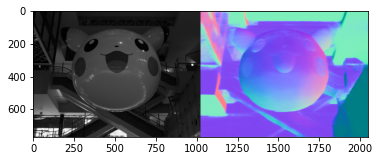

100%|██████████| 20000/20000 [9:02:57<00:00,  1.63s/it]  


In [21]:
num_iters = 1000
b_vis_normal = True
front_facing = False
in_thresh = 0.0
transform_name = 'tencrop_resize'

WP = namedtuple('WeightPath', ['name', 'path'])

pretrained_weights_paths = [
#     WP('full_aug_1e3', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/2nrpj0i4/last.ckpt'),
#     WP('partial_aug_1e4v2', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/17d8udjm/last.ckpt'),
#     WP('partial_aug_1e3', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/1zeqrirc/last.ckpt'),
#     WP('full_aug_1e4', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/37kwjmko/last.ckpt'),
#     WP('full_aug_size_512_cos_l1_1e4_bk', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/3i8uv0k8/backup3.ckpt'),
#     WP('full_aug_size_512_cos_l1_1e4_bk', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/3i8uv0k8/backup4.ckpt'),


#     WP('full_aug_size_512_cos_l1_1e4', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/3i8uv0k8/epoch=2-v1.ckpt'),
#     WP('full_aug_size_512_cos_l1_1e4_bk', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/3i8uv0k8/backup9.ckpt'),
#     WP('full_aug_size_512_l1_1e3_oasis_val', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/owmw838g/epoch=1-v0.ckpt'),
#     WP('full_aug_size_512_cos_l1_1e4_oasis_val', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/21ztdscu/epoch=0-v0.ckpt'),
#     WP('full_aug_size_512_cos_l1_1e4_oasis_val_augment', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/1d7d3qt1/epoch=0-v1.ckpt'),

#     WP('full_aug_size_512_cos_l1_1e3', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/2t4krb4o/epoch=1-v0.ckpt'),
#     WP('full_aug_size_512_cos_1e4', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/2trxgqjm/epoch=2-v0.ckpt'),

#     WP('partial_aug_1e4', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/4l635hxn/epoch=5.ckpt'),
#     WP('full_aug_size_512_cos_l1_1e5', '/scratch/ainaz/omnidata2/experiments/normal/checkpoints/omnidata/2tdo6nx9/epoch=0-v0.ckpt'),

    WP('best_MAE', '/scratch/sasha/omnidata/best_checkpoints/best_MAE_1k.pth'),
    
]



# crop_transforms = tta.Product(
#     [
#         tta.SurfaceNormalHorizontalFlip(dim_horizontal=0),
#         tta.FiveCrops(0.9),
#         tta.ResizeShortestEdge([512, 256]),
#     ]
# )

# whole_transforms = tta.Product(
#     [
#         tta.SurfaceNormalHorizontalFlip(dim_horizontal=0),
#         tta.ResizeShortestEdge([512, 256, 320, 384, 448]),

#     ]
# )

# transforms = whole_transforms
# transforms = list(it.chain(crop_transforms, whole_transforms))

transforms = ALL_TRANSFORMS[transform_name]


for wp in pretrained_weights_paths:
    with torch.no_grad():
        pretrained_weights_path = wp.path
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        model = UNet(in_channels=3, out_channels=3)

        checkpoint = torch.load(pretrained_weights_path, map_location='cuda:0')
        if 'state_dict' in checkpoint:
            state_dict = {}
            for k, v in checkpoint['state_dict'].items():
                state_dict[k.replace('model.', '')] = v
        else:
              state_dict = checkpoint
        model.load_state_dict(state_dict)
        model.to(device)
        model.eval().cuda()
        
        def model_fn(x):
            output_var = (model(x))* 2 - 1
            output_var[:,2,:,:] *= -1
            output_var = torch.nn.functional.normalize(output_var, p=2, dim=1)
            return output_var

        wrapper = tta.SurfaceNormalsTTAWrapper(model=model_fn, transforms=transforms, run_mode='serial', merger_fn=tta.MedianMerger)
        wrapper_fn = lambda x: torch.nn.functional.normalize(wrapper(x), p=2, dim=1)

        print("\n\n")
        print(f'+----------------------------------+')
        print(f'|  {wp.name}')
        print(f'+----------------------------------+')
        
        test_csv = '/scratch/ainaz/OASIS/OASIS_test/OASIS_test.csv'
        out_folder = '/scratch/ainaz/OASIS/normals'
        list_of_imgs = get_img_list(test_csv)
        print( "Testing on %s" % test_csv )
        run(wrapper_fn, list_of_imgs, out_folder, False)
